# Decompositions and Plots

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 26 14:06:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

Cloning into 'Tensor-Decompositions-OPM-MEG'...
remote: Enumerating objects: 411, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 411 (delta 46), reused 52 (delta 21), pack-reused 316 (from 1)
Receiving objects: 100% (411/411), 33.99 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (193/193), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.7 MB/s eta 0:00:00


In [5]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 88.3 MB/s eta 0:00:00


# Outcome

In [6]:
mat_file = 'Outcome_trimmed_TFR_ROI_Averaged.mat'

with h5py.File(mat_file, 'r') as f:
    # Load raw and baseline-normalized tensors
    tensor = np.array(f['tensor'])           # [Trials x ROIs x Freq x Time] - raw power
    tensor_norm = np.array(f['tensor_norm']) # [Trials x ROIs x Freq x Time] - baseline normalized

    time_vec = np.array(f['time_vec']).flatten()
    freq_vec = np.array(f['freq_vec']).flatten()

    # ROI labels (stored as HDF5 references)
    roi_labels = [''.join(chr(c) for c in f[ref][:].flatten()) for ref in f['roi_labels'][:].flatten()]

print(f"Tensor shape (raw): {tensor.shape}")
print(f"Tensor shape (normalized): {tensor_norm.shape}")
print(f"Time: {time_vec[0]*1000:.0f} to {time_vec[-1]*1000:.0f} ms ({len(time_vec)} points)")
print(f"Freq: {freq_vec[0]:.0f} to {freq_vec[-1]:.0f} Hz ({len(freq_vec)} points)")
print(f"ROIs: {len(roi_labels)}")



Tensor shape (raw): (101, 34, 166, 1)
Tensor shape (normalized): (101, 34, 166, 1)
Time: 0 to 1000 ms (101 points)
Freq: 4 to 70 Hz (34 points)
ROIs: 166


In [7]:
# Find which tissues are missing
tissue_nums = {int(label.replace("tissue", "").strip()) for label in roi_labels}
missing = sorted(set(range(1, 171)) - tissue_nums)
print(f"Missing: {missing}")

Missing: [35, 36, 81, 82]


In [10]:
tensor = tensor.T
tensor_norm = tensor_norm.T

In [11]:

pow = np.squeeze(tensor, axis=0)
pow.shape

(166, 34, 101)

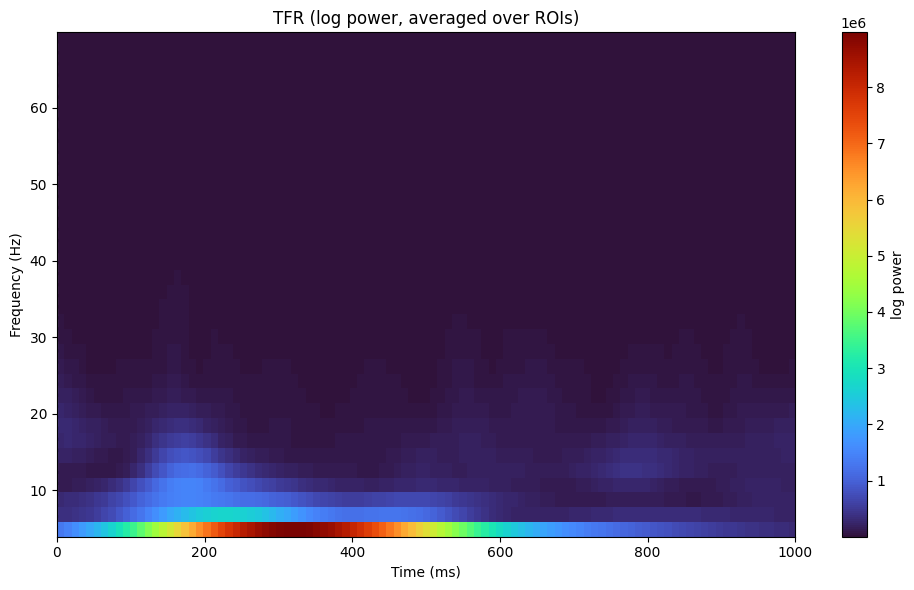

In [12]:
# Average over trials and ROIs
pow_avg = np.nanmean(pow, axis=0)  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

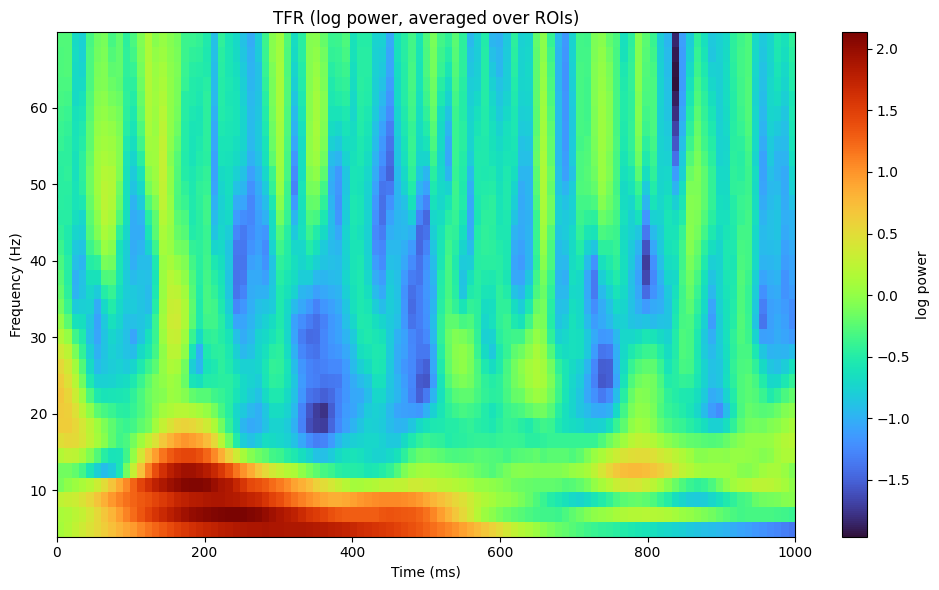

In [13]:
# Average over trials and ROIs
pow_avg = np.nanmean(tensor_norm, axis=(0,1))  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [14]:
pow.shape

(166, 34, 101)

In [15]:

pow_norm = np.squeeze(tensor_norm, axis=0)
pow_norm.shape


(166, 34, 101)

In [16]:
np.all(tensor_norm > 0)

np.False_

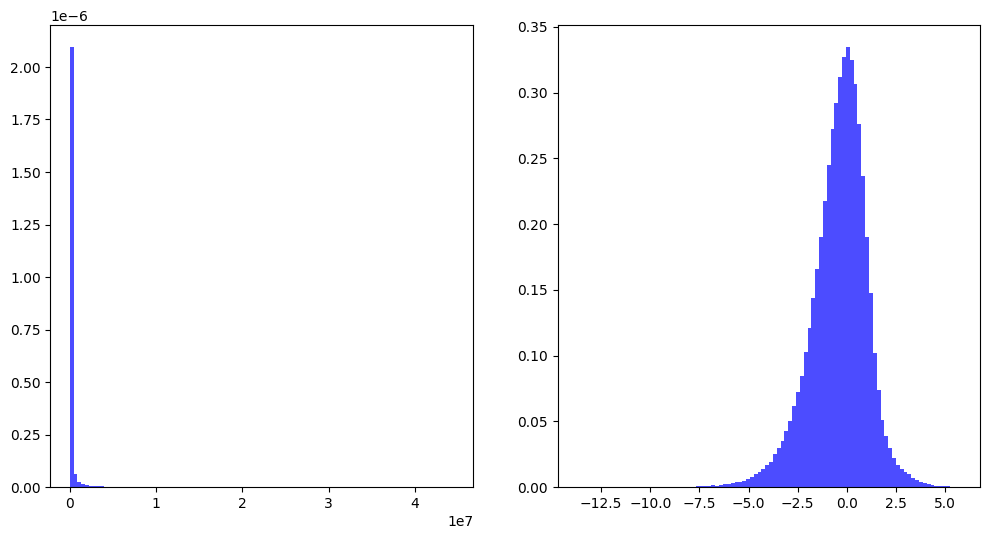

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].hist(pow.ravel(), bins=100, density=True, color='blue', alpha=0.7);
ax[1].hist(pow_norm.ravel(), bins=100, density=True, color='blue', alpha=0.7);

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_pow_torch = torch.as_tensor(pow_norm, device=device, dtype=torch.float32)
log_pow_torch.shape[0]

166

In [19]:
%cd Tensor-Decompositions-OPM-MEG/

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [20]:
from src.tools.rankselection import rank_selection, suggest_rank, stability_plot, fit_plot,  corcondia, run_parafac

In [23]:
NON_NEGATIVE_MODES = [1, 2]
ranks = range(1,15,1)

results = rank_selection(
    log_pow_torch,
    ranks=ranks,
    n_repeats=15,
    non_negative_modes=NON_NEGATIVE_MODES,
    verbose=1
)

Using non-negative constraints on modes: [1, 2]

=== Rank 1 ===
--- Testing Rank 1 with 15 repeats (non-negative modes: [1, 2]) ---
Rank 1: Best Error=1087.2734 | Mean Similarity=1.0000
Rank 1: Stability=1.000±0.000, R²=-0.012±0.000

=== Rank 2 ===
--- Testing Rank 2 with 15 repeats (non-negative modes: [1, 2]) ---
Rank 2: Best Error=1076.1875 | Mean Similarity=0.8262
Rank 2: Stability=0.826±0.280, R²=0.009±0.005

=== Rank 3 ===
--- Testing Rank 3 with 15 repeats (non-negative modes: [1, 2]) ---
Rank 3: Best Error=1070.0430 | Mean Similarity=0.7629
Rank 3: Stability=0.763±0.229, R²=0.020±0.004

=== Rank 4 ===
--- Testing Rank 4 with 15 repeats (non-negative modes: [1, 2]) ---
Rank 4: Best Error=1065.3519 | Mean Similarity=0.6621
Rank 4: Stability=0.662±0.180, R²=0.028±0.004

=== Rank 5 ===
--- Testing Rank 5 with 15 repeats (non-negative modes: [1, 2]) ---
Rank 5: Best Error=1062.0349 | Mean Similarity=0.6836
Rank 5: Stability=0.684±0.194, R²=0.034±0.007

=== Rank 6 ===
--- Testing Ran

In [24]:
stabilities = results['stabilities']
stds = results['stab_stds']

fits = results['fits']
fits_stds = results['fit_stds']

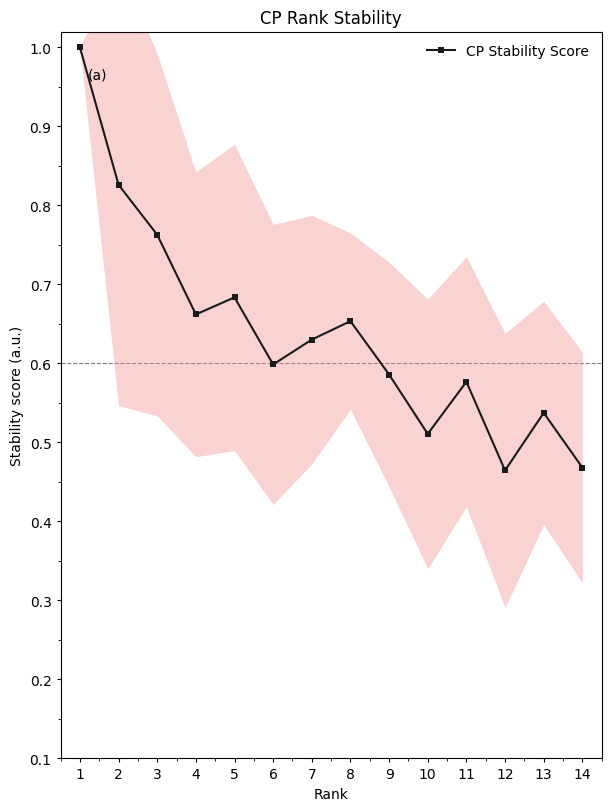

In [53]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(6, 8),
    constrained_layout=True
)

def panel(a, y, yerr, title, panel_label):
    # Uncertainty as a band
    a.fill_between(
        ranks, y - yerr, y + yerr,
        color="lightcoral", alpha=0.35, linewidth=0, zorder=1
    )

    # Mean line + markers
    a.plot(
        ranks, y, "s-",
        color="0.1",
        markersize=4,
        markerfacecolor="0.1",
        markeredgewidth=0,
        zorder=2,
        label="CP Stability Score"
    )

    # Reference line
    a.axhline(0.6, color="0.5", ls="--", lw=0.8, zorder=0)

    # Axes formatting
    a.set_title(title)
    a.set_xlim(0.5, max(ranks) + 0.5)
    a.set_xticks(ranks)
    a.tick_params(direction="out", length=3, width=0.8)
    a.tick_params(which="minor", direction="out", length=2, width=0.6)

    # Minor ticks without clutter
    a.xaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(0.1))

    # Panel label
    a.text(0.05, 0.95, panel_label, transform=a.transAxes,
           va="top", ha="left")

panel(ax, np.asarray(stabilities), np.asarray(stds),
      "CP Rank Stability", "(a)")

ax.set_ylabel("Stability score (a.u.)")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.02)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

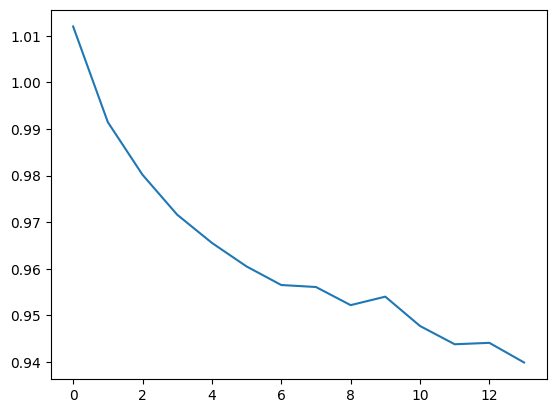

In [35]:
fit_vals = [1-f for f in fits]

plt.plot(fit_vals)

In [41]:
from tensorly.cp_tensor import cp_normalize
from tensorly.decomposition import parafac
import tensorly as tl
tl.set_backend('pytorch')

In [27]:
%cd ..

/content/drive/MyDrive/OPM-MEG


In [28]:
aal_nifti_path = 'AAL3v1_1mm.nii'

In [29]:
def load_aal3_labels(txt_path, n_rois=None):
    """
    Load AAL3 atlas labels from text file.

    Parameters:
        txt_path : str
            Path to label file
        n_rois : int, optional
            If provided, only return first n_rois labels (to match tensor size)

    Returns:
        labels : list of str
    """
    labels = []

    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) >= 2:
                labels.append(parts[1])

    # Truncate if needed
    if n_rois is not None:
        if n_rois < len(labels):
            print(f"Truncating labels from {len(labels)} to {n_rois}")
            print(f"Excluded ROIs: {labels[n_rois:]}")
            labels = labels[:n_rois]

    print(f"Loaded {len(labels)} AAL3 labels")
    return labels

aal3_full = load_aal3_labels('AAL3v1.nii.txt')

aal3_filtered = [label for i, label in enumerate(aal3_full) if (i + 1) not in missing]

print(len(aal3_filtered))


Loaded 170 AAL3 labels
166


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from matplotlib.gridspec import GridSpec

def to_numpy(x):
    """Safely converts PyTorch Tensors to NumPy arrays."""
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    elif hasattr(x, "numpy"):
        return x.numpy()
    else:
        return np.array(x)


def plot_factors_on_atlas(A, B, C, roi_labels, full_atlas_labels, aal_nifti_path,
                          freq_vec=None, time_vec=None,
                          top_n_rois=10,           # NEW: Show top N ROIs
                          threshold_percentile=75,  # NEW: Threshold for brain plot
                          global_normalize=False):  # NEW: Option for cross-component comparison
    """
    Plot CP factors with improved ROI visualization.

    Parameters
    ----------
    A : array (n_rois, R)
        ROI/spatial weights
    B : array (n_freqs, R)
        Frequency weights
    C : array (n_times, R)
        Time weights
    roi_labels : list
        Names of ROIs in your decomposition
    full_atlas_labels : list
        All labels in the atlas
    aal_nifti_path : str
        Path to AAL atlas NIfTI file
    freq_vec : array, optional
        Frequency axis values
    time_vec : array, optional
        Time axis values (in seconds, will be converted to ms)
    top_n_rois : int
        Number of top ROIs to show in bar plot
    threshold_percentile : float
        Percentile threshold for brain visualization (0-100)
    global_normalize : bool
        If True, normalize across all components for comparison
    """
    # --- 1. CONVERT INPUTS TO NUMPY ---
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)

    # --- 2. PRE-LOAD ATLAS ---
    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]

    # --- 3. COMPUTE GLOBAL NORMALIZATION IF REQUESTED ---
    # This allows fair comparison across components
    if global_normalize:
        global_max = np.max(np.abs(A))
    else:
        global_max = None

    # --- 4. DEFAULT AXES ---
    if freq_vec is None:
        freq_vec = np.linspace(0, 70, B.shape[0])
    else:
        freq_vec = to_numpy(freq_vec)

    if time_vec is None:
        time_vec = np.linspace(0, 1000, C.shape[0])
    else:
        time_vec = to_numpy(time_vec) * 1000  # Convert to ms

    for r in range(R):

        fig = plt.figure(figsize=(18, 8))
        gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 0.8],
                      width_ratios=[1.2, 1, 1, 1], hspace=0.3, wspace=0.3)

        fig.suptitle(f"Component {r+1}", fontsize=16, fontweight='bold')


        roi_weights = A[:, r].copy()

        # Check for and report NaN values
        n_nans = np.sum(np.isnan(roi_weights))
        if n_nans > 0:
            print(f"  Warning: Component {r+1} has {n_nans} NaN ROI weights")
        roi_weights = np.nan_to_num(roi_weights, nan=0.0)

        # --- NORMALIZATION ---
        if global_normalize and global_max > 0:
            # Normalize by global max (comparable across components)
            roi_weights_norm = roi_weights / global_max
            norm_label = "Weight (global norm)"
        else:
            # Normalize by this component's max
            max_abs = np.max(np.abs(roi_weights))
            if max_abs > 0:
                roi_weights_norm = roi_weights / max_abs
            else:
                roi_weights_norm = roi_weights
            norm_label = "Weight (normalized)"


        brain_vol = np.zeros(aal_data.shape, dtype=float)
        mapped_rois = 0
        missing_rois = []

        for i, roi_name in enumerate(roi_labels):
            w = float(roi_weights_norm[i])
            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                atlas_id = atlas_idx + 1
                brain_vol[aal_data == atlas_id] = w
                mapped_rois += 1
            except ValueError:
                missing_rois.append(roi_name)

        # Report mapping issues
        if missing_rois:
            print(f"  Component {r+1}: {len(missing_rois)} ROIs not found in atlas")

        weight_nii = nib.Nifti1Image(brain_vol, affine)

        # --- COMPUTE THRESHOLD ---
        nonzero_weights = np.abs(roi_weights_norm[roi_weights_norm != 0])
        if len(nonzero_weights) > 0:
            threshold = np.percentile(nonzero_weights, threshold_percentile)
        else:
            threshold = None


        ax_glass = fig.add_subplot(gs[0, 0])
        plotting.plot_glass_brain(
            weight_nii,
            axes=ax_glass,
            display_mode="lyrz",  # Left, Y, Right, Z views
            threshold=threshold,
            colorbar=True,
            plot_abs=False,
            vmax=1.0,
            symmetric_cbar=True,
            cmap="RdBu_r",
            alpha=0.8
        )
        ax_glass.set_title(f"Glass Brain (thresh: {threshold_percentile}th %ile)")


        # Axial slices
        ax_stat = fig.add_subplot(gs[0, 1:])
        display = plotting.plot_stat_map(
            weight_nii,
            axes=ax_stat,
            display_mode="z",  # Axial slices
            cut_coords=7,      # Number of slices
            threshold=threshold,
            colorbar=True,
            vmax=1.0,
            symmetric_cbar=True,
            cmap="RdBu_r",
            title="Axial Slices"
        )

        # --- PLOT 3: TOP ROIs BAR PLOT (BOTTOM LEFT) ---
        ax_bar = fig.add_subplot(gs[1, 0])

        # Sort ROIs by absolute weight
        sorted_idx = np.argsort(np.abs(roi_weights))[::-1]
        top_idx = sorted_idx[:top_n_rois]

        top_weights = roi_weights[top_idx]  # Use original (unnormalized) weights
        top_names = [roi_labels[i] for i in top_idx]

        # Shorten long names for display
        short_names = [n[:20] + '...' if len(n) > 20 else n for n in top_names]

        # Color bars by sign
        colors = ['#d73027' if w > 0 else '#4575b4' for w in top_weights]

        y_pos = np.arange(len(top_weights))
        ax_bar.barh(y_pos, top_weights, color=colors, alpha=0.8, edgecolor='black')
        ax_bar.set_yticks(y_pos)
        ax_bar.set_yticklabels(short_names, fontsize=9)
        ax_bar.set_xlabel("Weight (raw)")
        ax_bar.set_title(f"Top {top_n_rois} ROIs")
        ax_bar.axvline(0, color='black', linewidth=0.8)
        ax_bar.invert_yaxis()  # Highest weight at top
        ax_bar.grid(True, axis='x', alpha=0.3)

        # --- PLOT 4: FREQUENCY (BOTTOM MIDDLE) ---
        ax_freq = fig.add_subplot(gs[1, 1:3])

        freq_weights = B[:, r]
        ax_freq.fill_between(freq_vec, freq_weights, alpha=0.3, color='blue')
        ax_freq.plot(freq_vec, freq_weights, color="blue", linewidth=2)

        # Mark frequency bands
        bands = {'δ': (1, 4), 'θ': (4, 8), 'α': (8, 13), 'β': (13, 30), 'γ': (30, 70)}
        for band_name, (f_low, f_high) in bands.items():
            f_mid = (f_low + f_high) / 2
            if freq_vec.min() <= f_mid <= freq_vec.max():
                ax_freq.axvspan(f_low, f_high, alpha=0.1, color='gray')
                ax_freq.text(f_mid, ax_freq.get_ylim()[1] * 0.95, band_name,
                           ha='center', fontsize=8, alpha=0.7)

        ax_freq.set_title("Frequency")
        ax_freq.set_xlabel("Frequency (Hz)")
        ax_freq.set_ylabel("Weight")
        ax_freq.set_xlim([freq_vec.min(), freq_vec.max()])
        ax_freq.grid(True, alpha=0.3)

        # --- PLOT 5: TIME (BOTTOM RIGHT) ---
        ax_time = fig.add_subplot(gs[1, 3])

        time_weights = C[:, r]
        ax_time.fill_between(time_vec, time_weights, alpha=0.3, color='green')
        ax_time.plot(time_vec, time_weights, color="darkgreen", linewidth=1.5)


        ax_time.set_title("Time")
        ax_time.set_xlabel("Time (ms)")
        ax_time.set_ylabel("Weight")
        ax_time.set_xlim([time_vec.min(), time_vec.max()])
        ax_time.grid(True, alpha=0.3)
        ax_time.legend(loc='upper right', fontsize=8)

        plt.tight_layout()
        plt.show()

        # --- PRINT SUMMARY ---
        print(f"\nComponent {r+1} Summary:")
        print(f"  Top 5 positive ROIs: {[roi_labels[i] for i in sorted_idx[:5] if roi_weights[i] > 0][:5]}")
        print(f"  Top 5 negative ROIs: {[roi_labels[i] for i in sorted_idx if roi_weights[i] < 0][:5]}")
        print(f"  Peak frequency: {freq_vec[np.argmax(np.abs(freq_weights))]:.1f} Hz")
        print(f"  Peak time: {time_vec[np.argmax(np.abs(time_weights))]:.0f} ms")

In [48]:
cp_tensor = run_parafac(log_pow_torch,  non_negative_modes=NON_NEGATIVE_MODES, rank=7)

In [49]:

weights,  factors = cp_tensor
A,B,C = factors

In [37]:
%cd OPM-MEG/

/content/drive/MyDrive/OPM-MEG


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


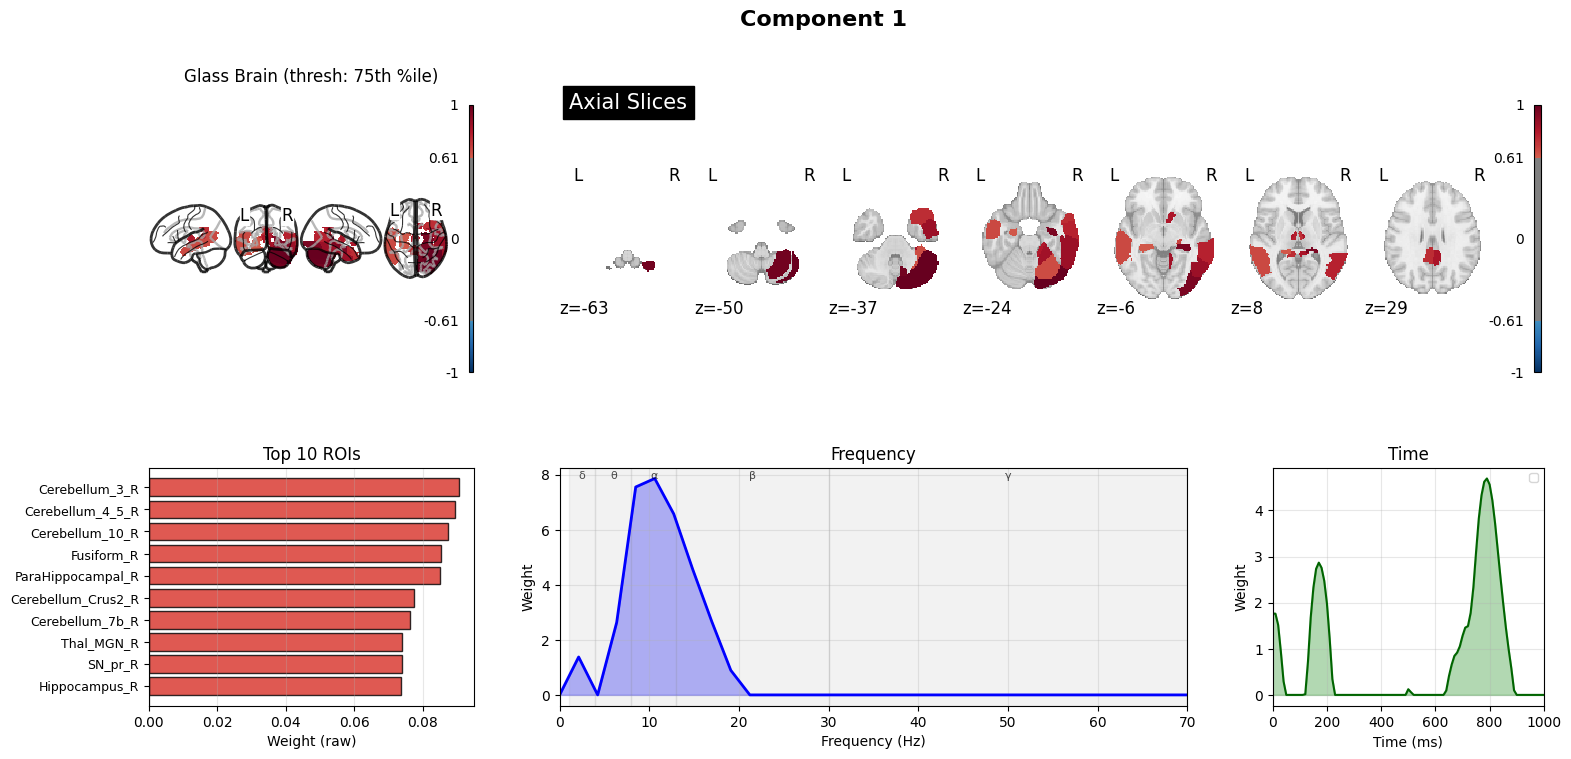


Component 1 Summary:
  Top 5 positive ROIs: ['Cerebellum_3_R', 'Cerebellum_4_5_R', 'Cerebellum_10_R', 'Fusiform_R', 'ParaHippocampal_R']
  Top 5 negative ROIs: []
  Peak frequency: 10.6 Hz
  Peak time: 790 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


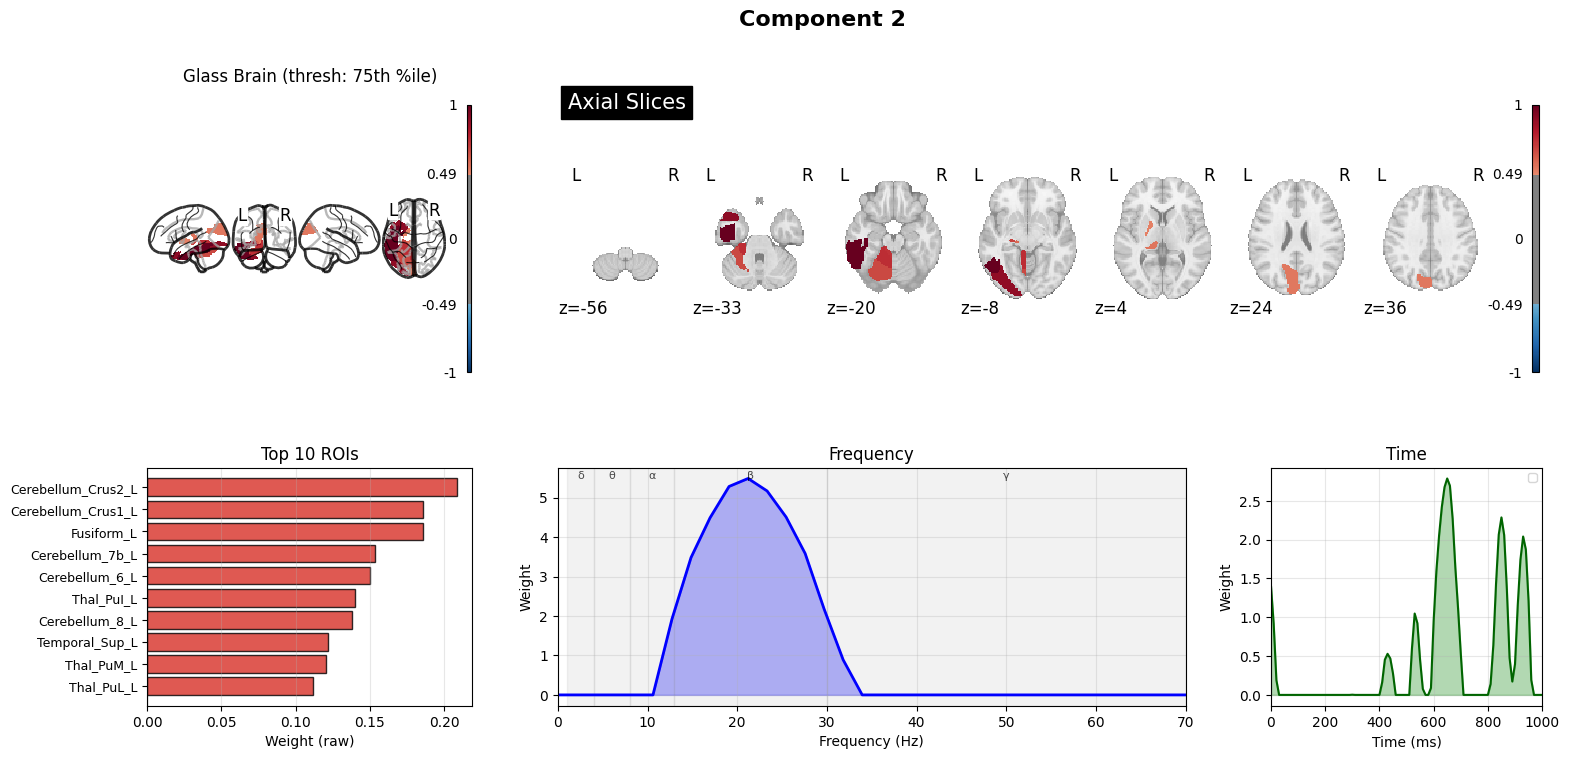


Component 2 Summary:
  Top 5 positive ROIs: ['Cerebellum_Crus2_L', 'Cerebellum_Crus1_L', 'Fusiform_L', 'Cerebellum_7b_L', 'Cerebellum_6_L']
  Top 5 negative ROIs: []
  Peak frequency: 21.2 Hz
  Peak time: 650 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


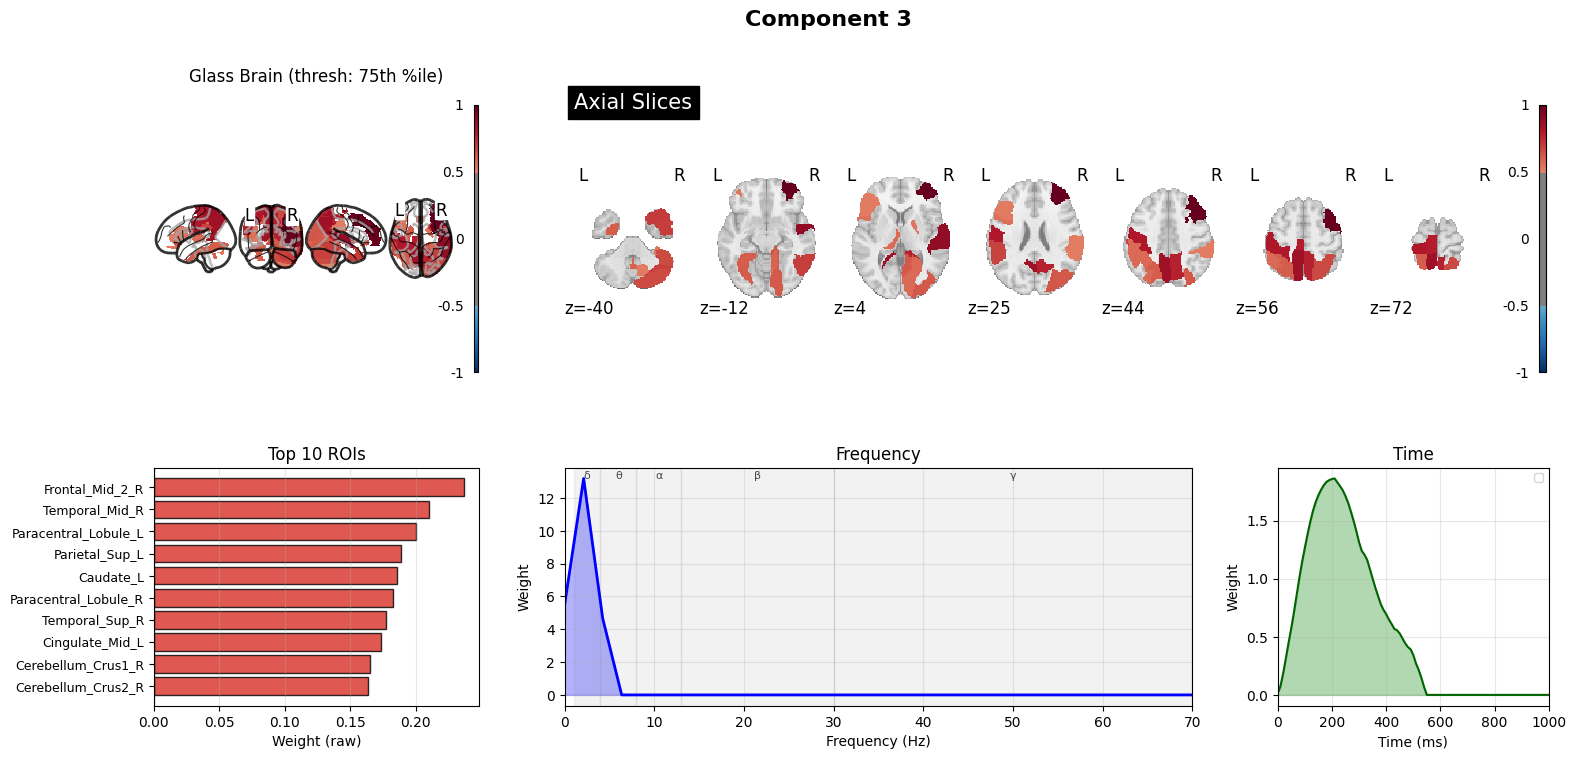


Component 3 Summary:
  Top 5 positive ROIs: ['Frontal_Mid_2_R', 'Temporal_Mid_R', 'Paracentral_Lobule_L', 'Parietal_Sup_L', 'Caudate_L']
  Top 5 negative ROIs: []
  Peak frequency: 2.1 Hz
  Peak time: 210 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


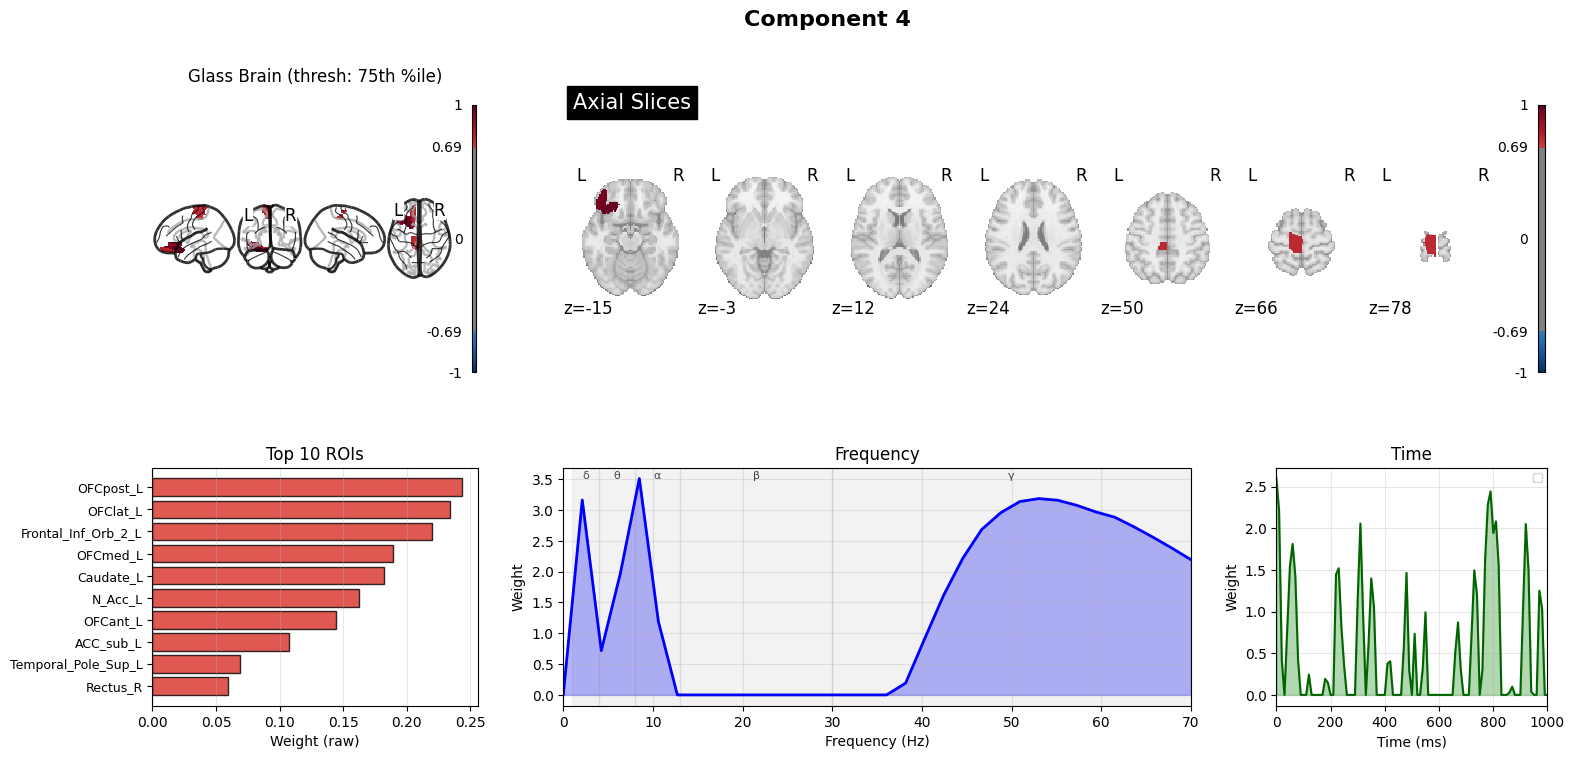


Component 4 Summary:
  Top 5 positive ROIs: ['OFCpost_L', 'OFClat_L', 'Frontal_Inf_Orb_2_L', 'OFCmed_L', 'Caudate_L']
  Top 5 negative ROIs: []
  Peak frequency: 8.5 Hz
  Peak time: 0 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


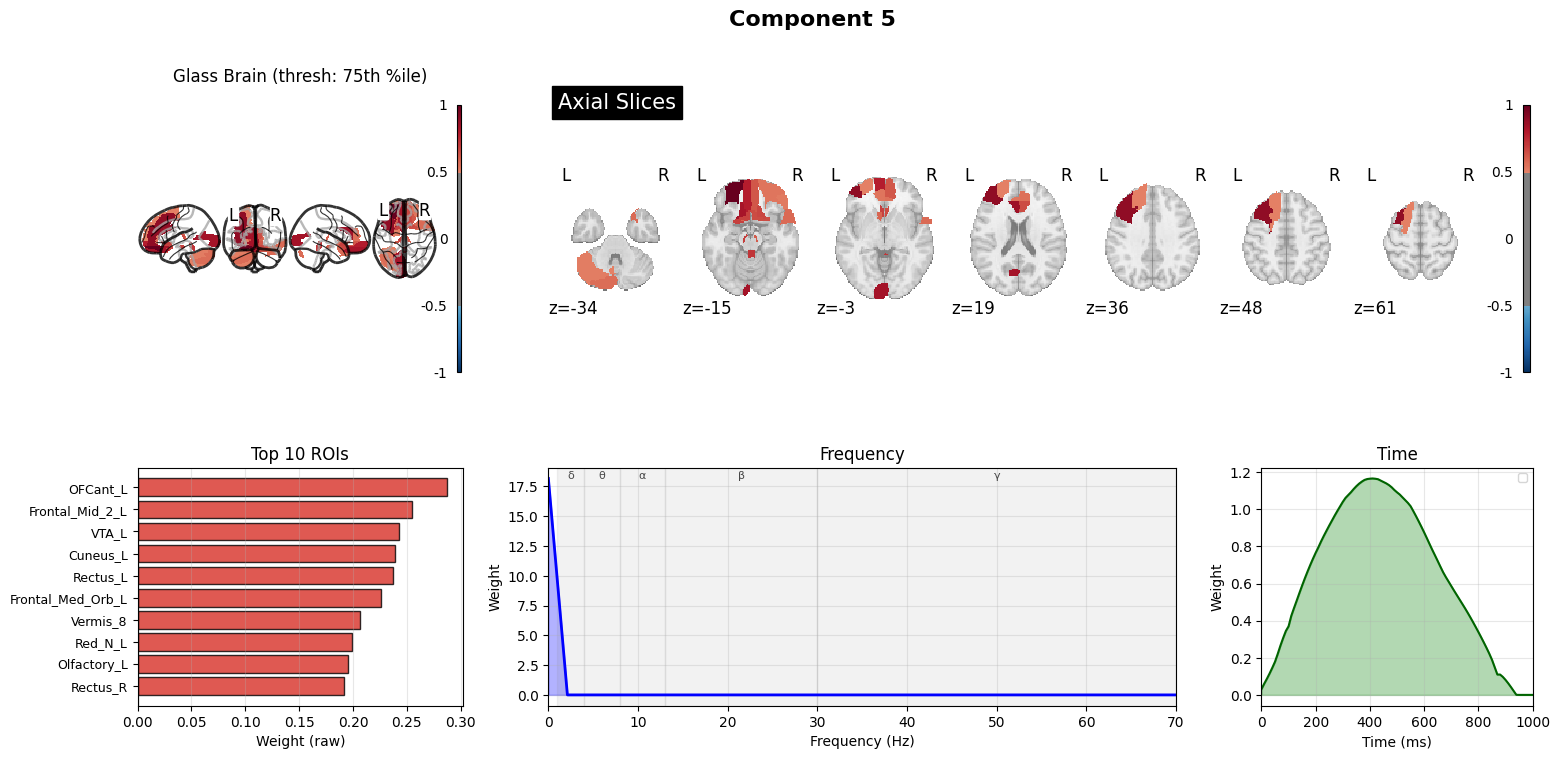


Component 5 Summary:
  Top 5 positive ROIs: ['OFCant_L', 'Frontal_Mid_2_L', 'VTA_L', 'Cuneus_L', 'Rectus_L']
  Top 5 negative ROIs: []
  Peak frequency: 0.0 Hz
  Peak time: 410 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


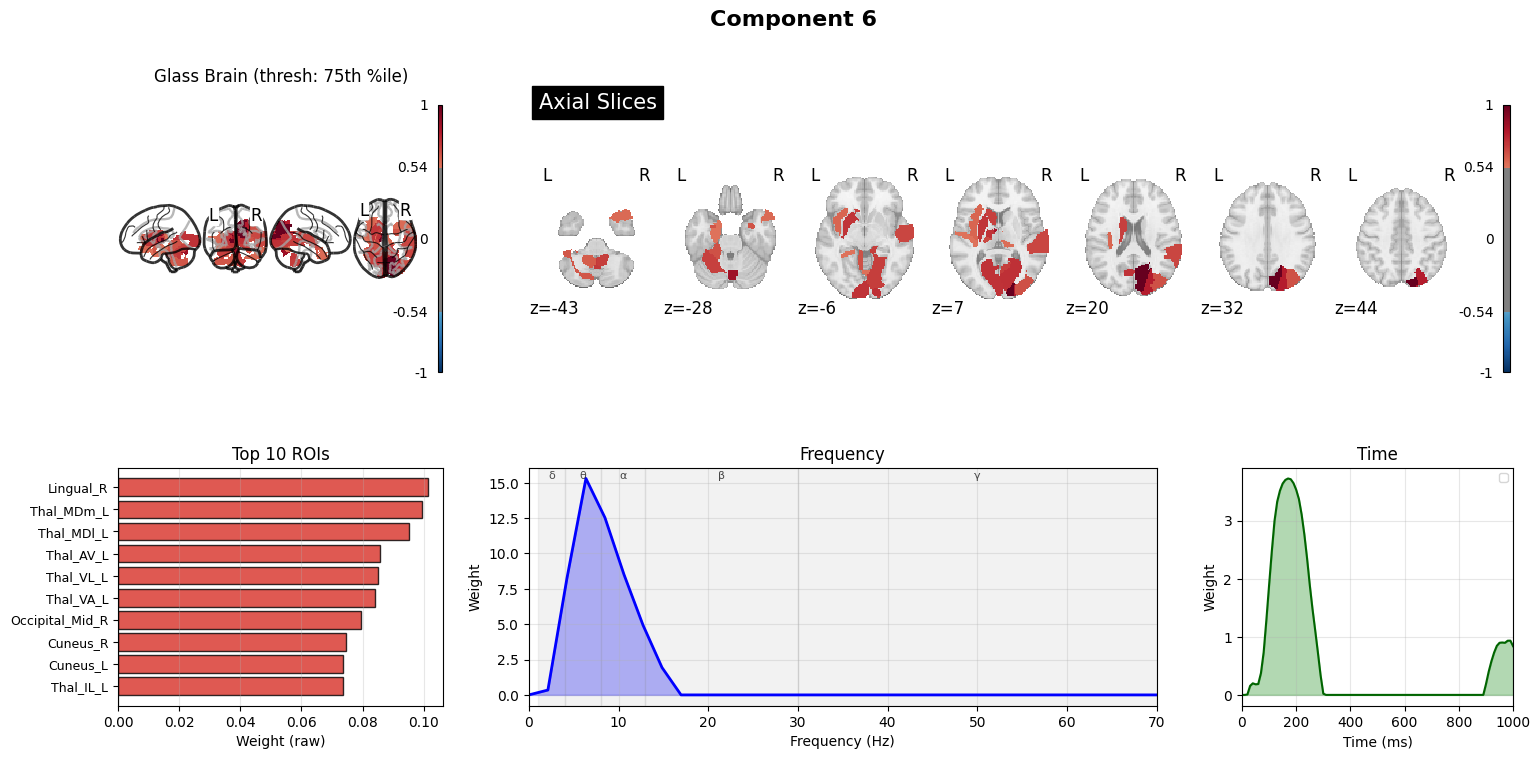


Component 6 Summary:
  Top 5 positive ROIs: ['Lingual_R', 'Thal_MDm_L', 'Thal_MDl_L', 'Thal_AV_L', 'Thal_VL_L']
  Top 5 negative ROIs: []
  Peak frequency: 6.4 Hz
  Peak time: 170 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


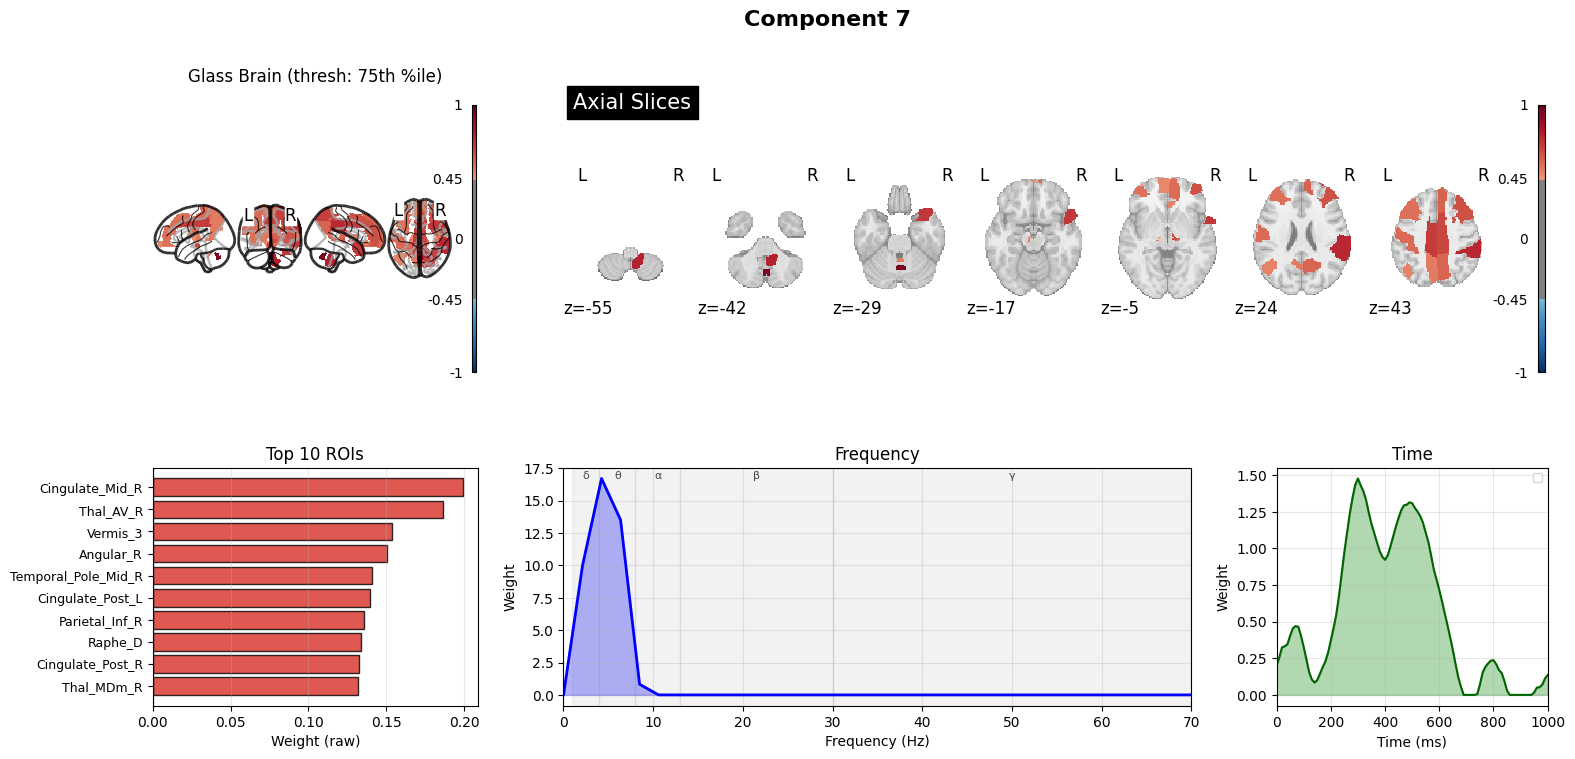


Component 7 Summary:
  Top 5 positive ROIs: ['Cingulate_Mid_R', 'Thal_AV_R', 'Vermis_3', 'Angular_R', 'Temporal_Pole_Mid_R']
  Top 5 negative ROIs: []
  Peak frequency: 4.2 Hz
  Peak time: 300 ms


In [50]:
plot_factors_on_atlas(A,B,C,aal3_filtered, aal3_filtered, aal_nifti_path)

/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


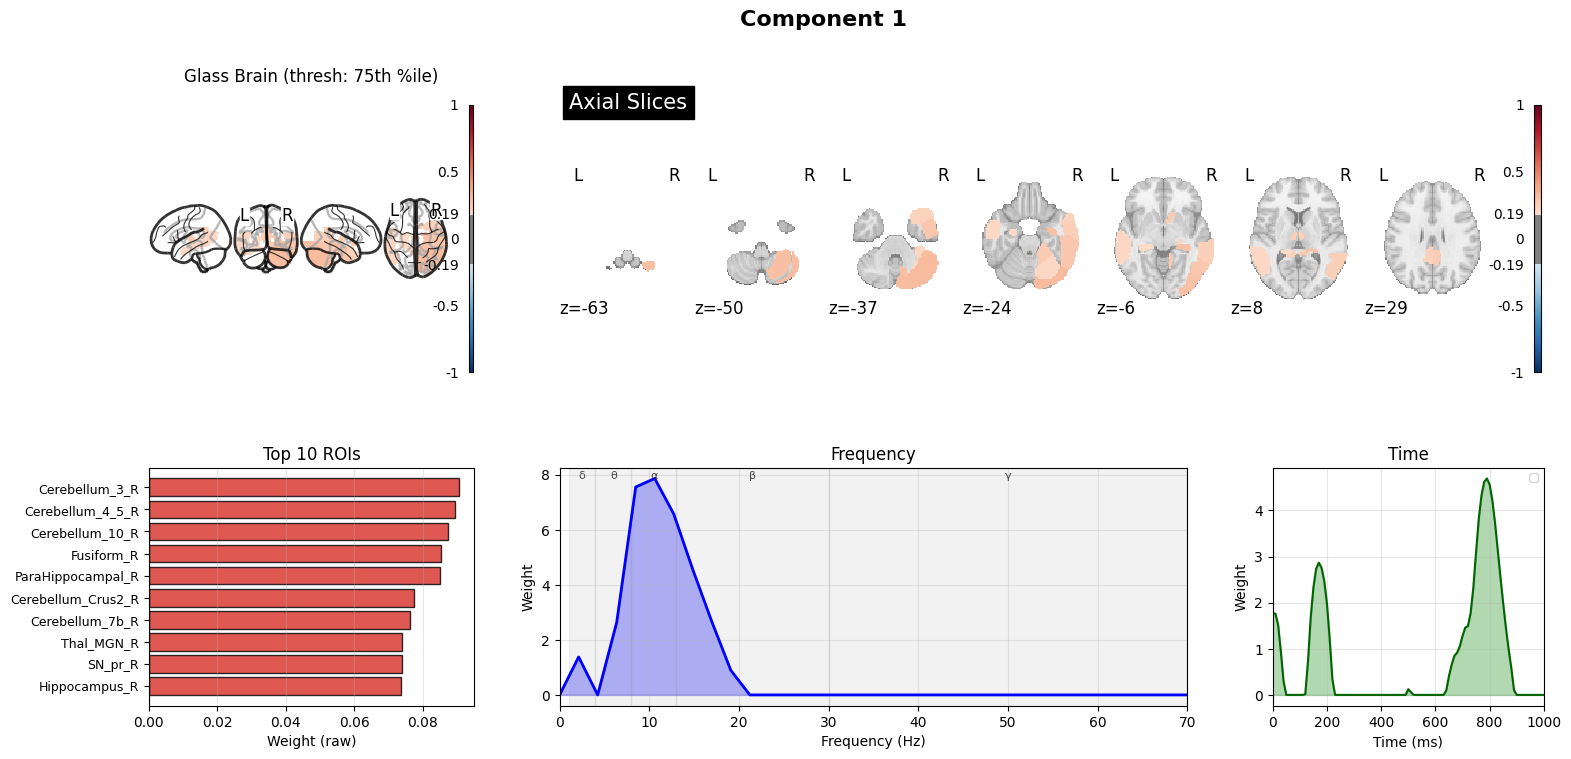


Component 1 Summary:
  Top 5 positive ROIs: ['Cerebellum_3_R', 'Cerebellum_4_5_R', 'Cerebellum_10_R', 'Fusiform_R', 'ParaHippocampal_R']
  Top 5 negative ROIs: []
  Peak frequency: 10.6 Hz
  Peak time: 790 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


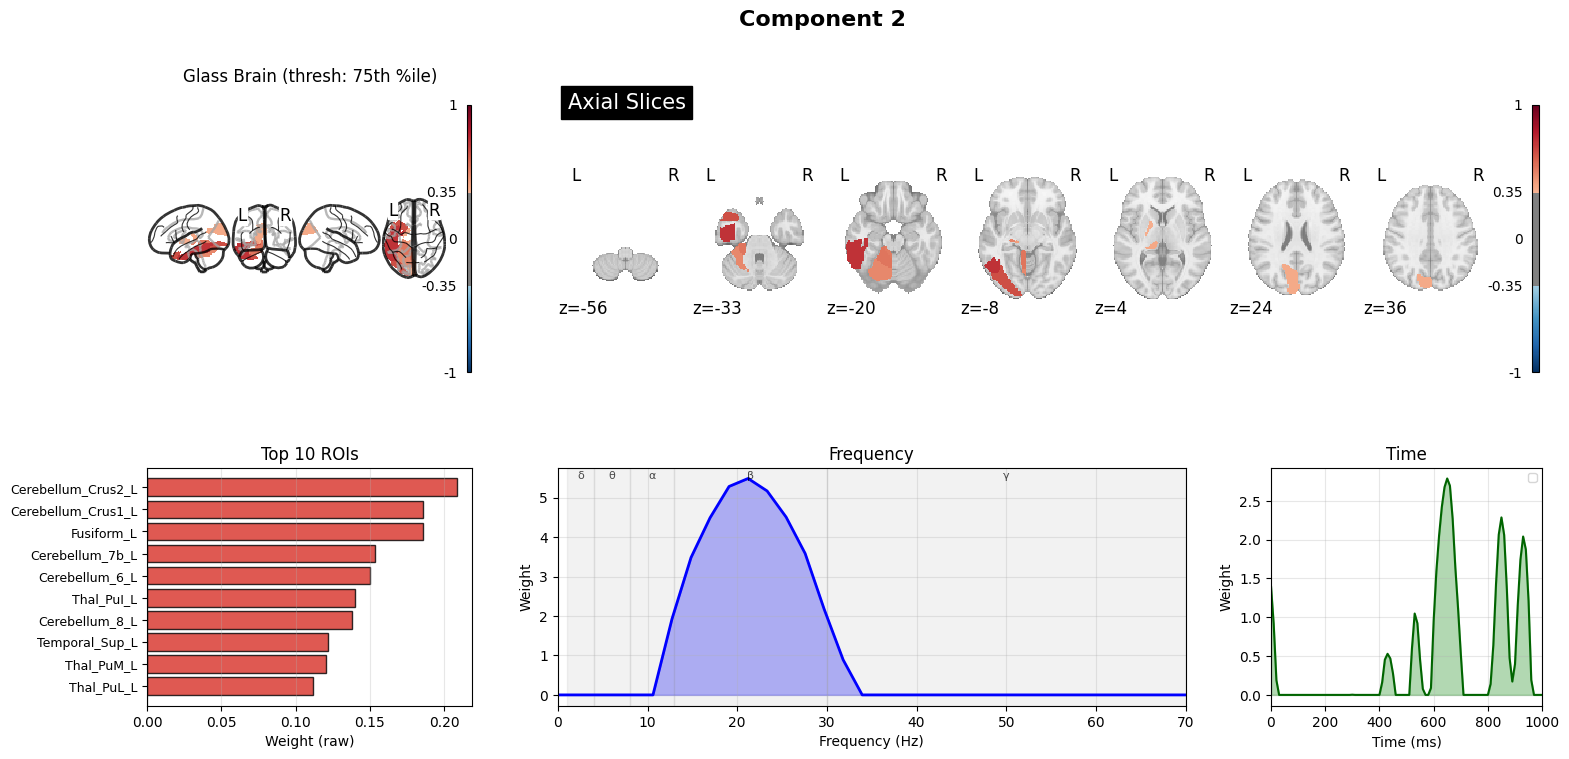


Component 2 Summary:
  Top 5 positive ROIs: ['Cerebellum_Crus2_L', 'Cerebellum_Crus1_L', 'Fusiform_L', 'Cerebellum_7b_L', 'Cerebellum_6_L']
  Top 5 negative ROIs: []
  Peak frequency: 21.2 Hz
  Peak time: 650 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


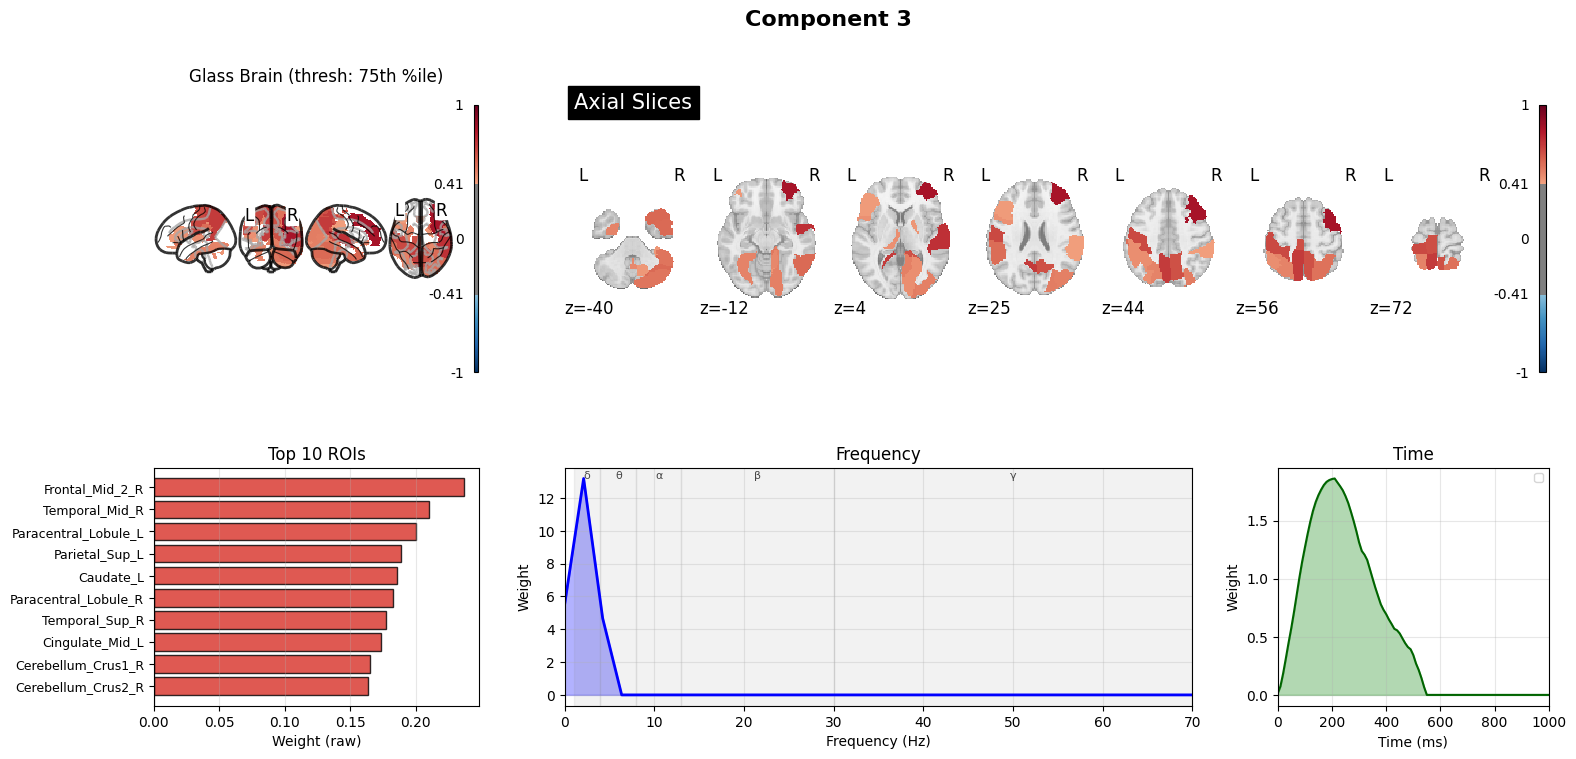


Component 3 Summary:
  Top 5 positive ROIs: ['Frontal_Mid_2_R', 'Temporal_Mid_R', 'Paracentral_Lobule_L', 'Parietal_Sup_L', 'Caudate_L']
  Top 5 negative ROIs: []
  Peak frequency: 2.1 Hz
  Peak time: 210 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


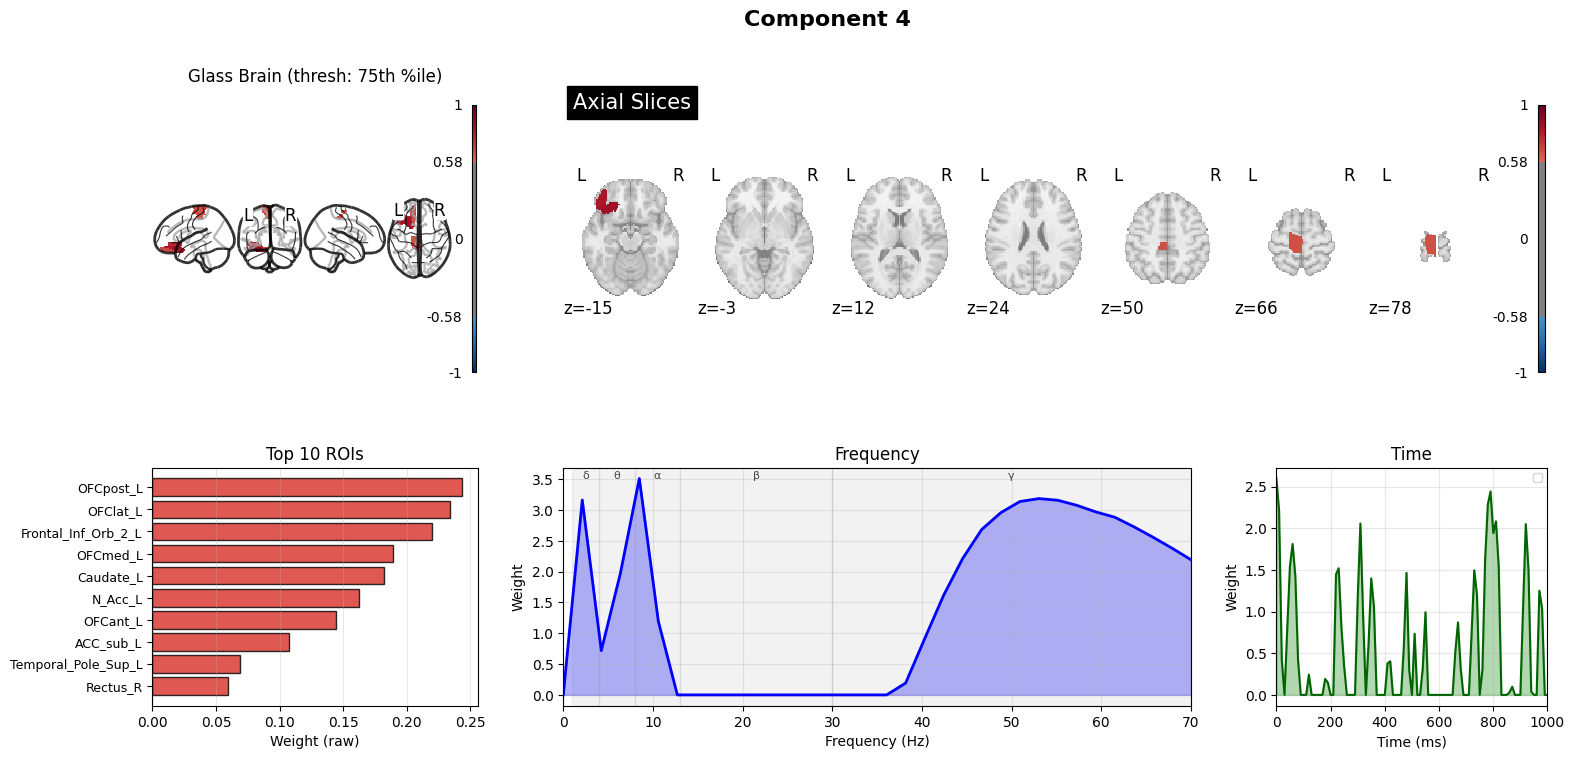


Component 4 Summary:
  Top 5 positive ROIs: ['OFCpost_L', 'OFClat_L', 'Frontal_Inf_Orb_2_L', 'OFCmed_L', 'Caudate_L']
  Top 5 negative ROIs: []
  Peak frequency: 8.5 Hz
  Peak time: 0 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


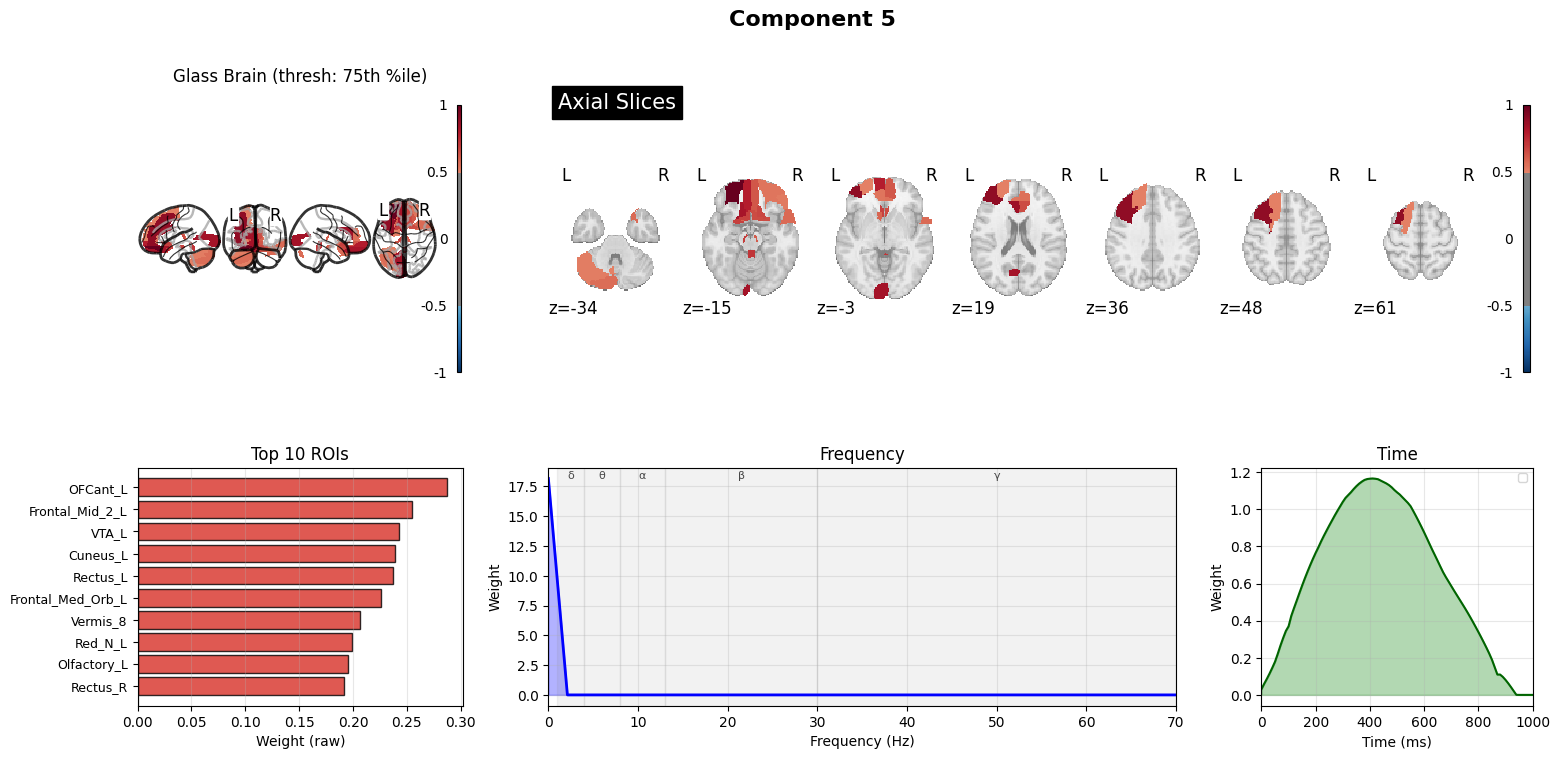


Component 5 Summary:
  Top 5 positive ROIs: ['OFCant_L', 'Frontal_Mid_2_L', 'VTA_L', 'Cuneus_L', 'Rectus_L']
  Top 5 negative ROIs: []
  Peak frequency: 0.0 Hz
  Peak time: 410 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


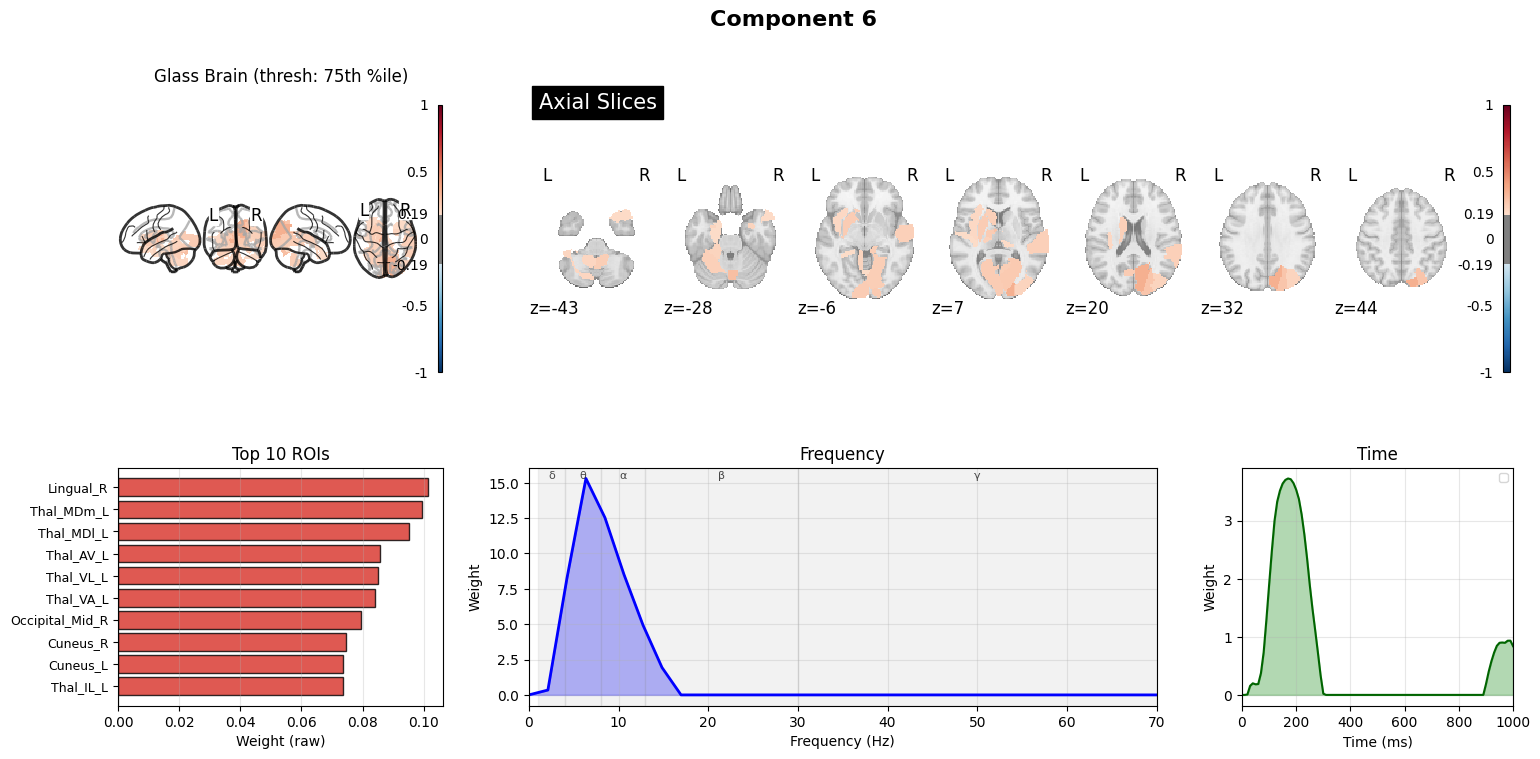


Component 6 Summary:
  Top 5 positive ROIs: ['Lingual_R', 'Thal_MDm_L', 'Thal_MDl_L', 'Thal_AV_L', 'Thal_VL_L']
  Top 5 negative ROIs: []
  Peak frequency: 6.4 Hz
  Peak time: 170 ms


/tmp/ipython-input-2998056346.py:232: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_time.legend(loc='upper right', fontsize=8)
/tmp/ipython-input-2998056346.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


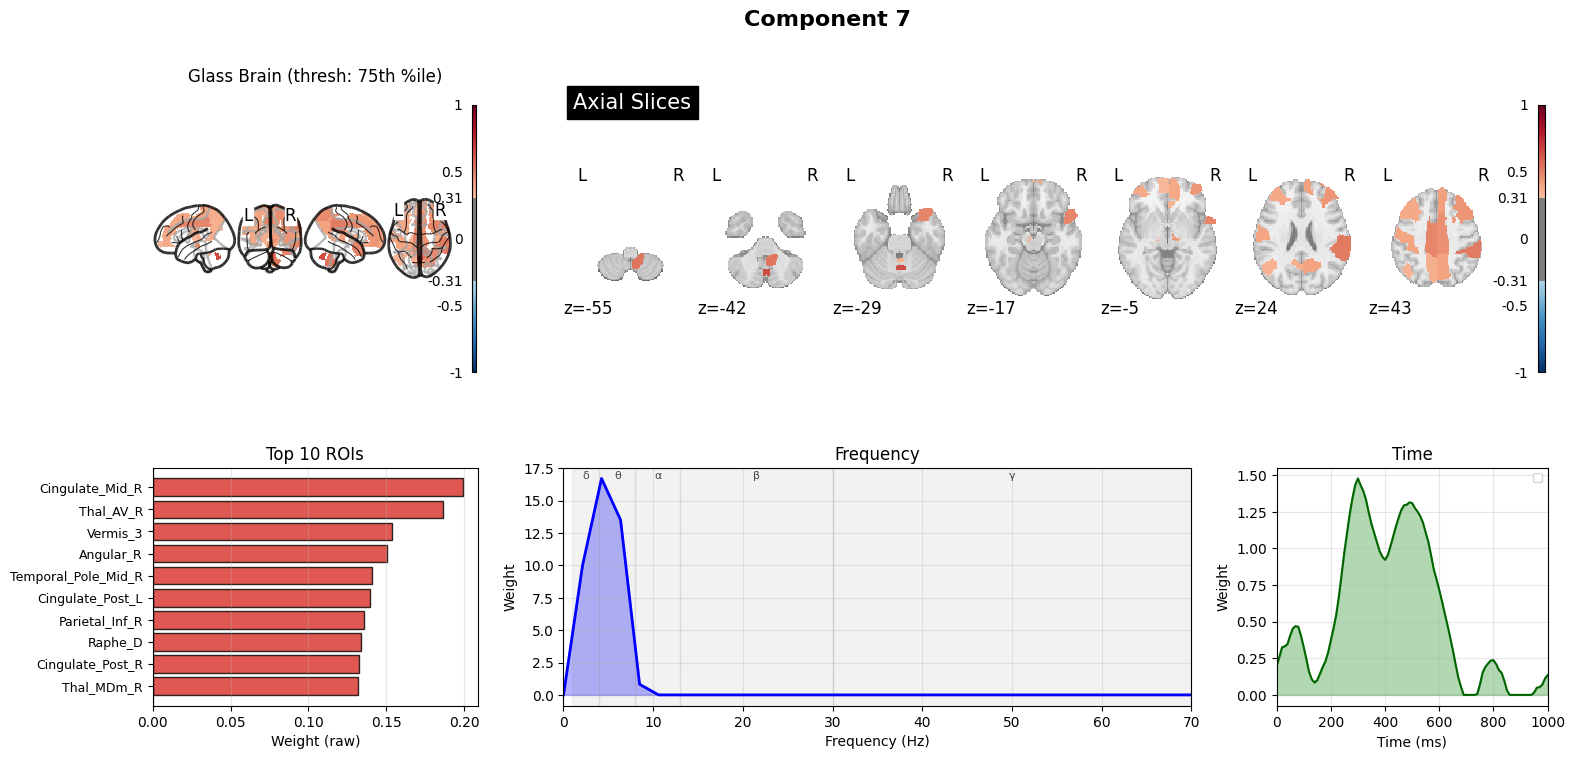


Component 7 Summary:
  Top 5 positive ROIs: ['Cingulate_Mid_R', 'Thal_AV_R', 'Vermis_3', 'Angular_R', 'Temporal_Pole_Mid_R']
  Top 5 negative ROIs: []
  Peak frequency: 4.2 Hz
  Peak time: 300 ms


In [52]:
plot_factors_on_atlas(A,B,C,aal3_filtered, aal3_filtered, aal_nifti_path, global_normalize=True)